## 1. Data Collection and Exploration

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
import sys
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb



In [2]:
# importing libraries
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# load the dataset and preview first five rows
data = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
# getting information of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
# getting the shape of the data
data.shape

(9093, 3)

Analysis of the Distribution of emotion Labels

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64


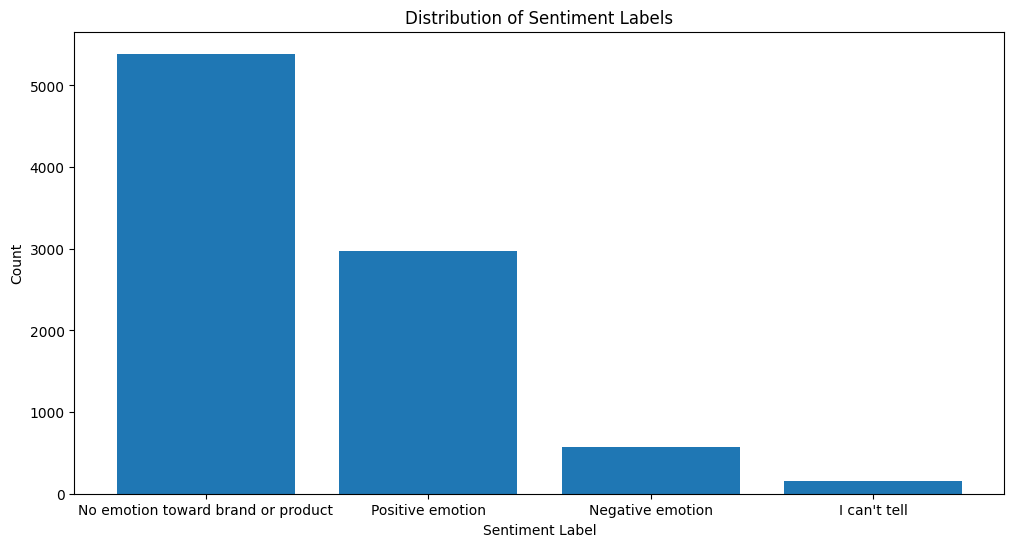

In [6]:
# Count the number of instances for each sentiment label
sentiment_counts = data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

# Display the counts
print(sentiment_counts)

plt.figure(figsize=(12, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Labels')
plt.show()


From the visualization, most people who tweeted dont have an emotion towards a brand or product and very few people we cant tell whether is positive, negative or have no emotion.

## 2. Data Preprocessing

### 2.1 Data Cleaning

- Dropping unwanted columns
- Handling missing values.
- Clean text data by removing special characters, URLs, and hashtags.
- Convert text to lowercase to ensure consistency.

2.1.1 Dropping unwanted columns

In [7]:
# dropping emotion_in_tweet_is_directed_at column since we wont be using it modelling
columns_to_drop = ['emotion_in_tweet_is_directed_at']
data = data.drop(columns=columns_to_drop)

In [8]:
# checking if the column has been dropped 
data.head()

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


The column has been dropped and we remain with the two columns that we will be using henceforth

2.1.2 Handling mising values

In [9]:
# checking if our dataset has missing values
data.isna().sum()

tweet_text                                            1
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

In [10]:
# dropping the row with missing values
# since we cannot impute text
data = data.dropna(subset=['tweet_text'])


In [11]:
# checking if the row with missing values has been dropped
data.isna().sum()

tweet_text                                            0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

2.1.3 Renaming columns

In [14]:
#renaming'is_there_an_emotion_directed_at_a_brand_or_product'column to emotion to make it easy to work with
data.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'}, inplace=True)

In [15]:
# previewing the first five rows to check if the column has been renamed.
data.head()

,tweet_text,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [16]:
# dropping 'i cant tell' and No emotion toward brand or product' category since we will only be using the two sentiments.
data = data[(data['emotion'] != "I can't tell") & (data['emotion'] != "No emotion toward brand or product")]


In [15]:
# Replacing 'No emotion toward brand or product' as neutral
#data['emotion'] = data['emotion'].replace({'No emotion toward brand or product': 'Neutral'})

In [17]:
# checking to see if 'i cant tell' category has been dropped and 'No emotion toward brand or product' has been replaced
data.emotion.value_counts()

emotion
Positive emotion    2978
Negative emotion     570
Name: count, dtype: int64

2.1.3 Cleaning text data

In [18]:
# Function to clean text
def clean_text(text):
    # Ensure text is a string
    text = str(text)
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove hashtags (including the # symbol)
    text = re.sub(r'#\w+', '', text)
    
    # Remove special characters and punctuation (except spaces)
    text = re.sub(r'[^\w\s]', '', text)
    
     # Convert text to lowercase
    text = text.lower()
    
    return text

# Apply the clean_text function to the "tweet_text" column
data['cleaned_tweet'] = data['tweet_text'].apply(clean_text)

# Display the DataFrame with cleaned text
print(data)



                                             tweet_text           emotion   
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...  Negative emotion  \
1     @jessedee Know about @fludapp ? Awesome iPad/i...  Positive emotion   
2     @swonderlin Can not wait for #iPad 2 also. The...  Positive emotion   
3     @sxsw I hope this year's festival isn't as cra...  Negative emotion   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...  Positive emotion   
...                                                 ...               ...   
9077  @mention your PR guy just convinced me to swit...  Positive emotion   
9079  &quot;papyrus...sort of like the ipad&quot; - ...  Positive emotion   
9080  Diller says Google TV &quot;might be run over ...  Negative emotion   
9085  I've always used Camera+ for my iPhone b/c it ...  Positive emotion   
9088                      Ipad everywhere. #SXSW {link}  Positive emotion   

                                          cleaned_tweet  
0     wesley83 i 

2.2 Tokenization


In [19]:
# Tokenize the "tweet_text" column
data['tokenized_tweet'] = data['cleaned_tweet'].apply(lambda x: word_tokenize(x))

# Display the DataFrame with tokenized text
print(data[['cleaned_tweet', 'tokenized_tweet']].head())

                                       cleaned_tweet   
0  wesley83 i have a 3g iphone after 3 hrs tweeti...  \
1  jessedee know about fludapp  awesome ipadiphon...   
2  swonderlin can not wait for  2 also they shoul...   
3  sxsw i hope this years festival isnt as crashy...   
4  sxtxstate great stuff on fri  marissa mayer go...   

                                     tokenized_tweet  
0  [wesley83, i, have, a, 3g, iphone, after, 3, h...  
1  [jessedee, know, about, fludapp, awesome, ipad...  
2  [swonderlin, can, not, wait, for, 2, also, the...  
3  [sxsw, i, hope, this, years, festival, isnt, a...  
4  [sxtxstate, great, stuff, on, fri, marissa, ma...  


2.3 Text Vectorization

In [20]:
# Join the tokenized words into a single string for each document
data['tokenized_tweet'] = data['tokenized_tweet'].apply(lambda x: ' '.join(x))

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform your tokenized text
tfidf_matrix = tfidf_vectorizer.fit_transform(data['tokenized_tweet'])


2.4 Label Encoding

To convert emotion column (negative, neutral, positive) into numerical format 0,1,2 respectively for model training using LabelEncoder()

In [21]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to the 'emotion' column
data['emotion_encoded'] = label_encoder.fit_transform(data['emotion'])

# Display the DataFrame with the encoded emotion labels
print(data[['emotion', 'emotion_encoded']].head())


            emotion  emotion_encoded
0  Negative emotion                0
1  Positive emotion                1
2  Positive emotion                1
3  Negative emotion                0
4  Positive emotion                1


## 3. Modelling

3.1 Data Splitting

Dividing the dataset into separate subsets to serve different purposes during the model development and evaluation process that is training set, validation set, and test set

In [22]:
# Splitting the data into labels and features(X, y) variables
X = data['tokenized_tweet']  # Features
y = data['emotion_encoded']  # Labels

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_valid_tfidf = tfidf_vectorizer.transform(X_valid)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


3.2 Baseline Model using Naive Bayes

In [23]:
# Baseline model using Naive Bayes
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_tfidf, y_train)
y_pred_nb = naive_bayes.predict(X_valid_tfidf)

# calculate accuracy
print("Naive Bayes Accuracy:", accuracy_score(y_valid, y_pred_nb))

# Calculate additional evaluation metrics
print("Classification Report:")
print(classification_report(y_valid, y_pred_nb))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred_nb))

Naive Bayes Accuracy: 0.8327067669172933
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.04      0.08        93
           1       0.83      1.00      0.91       439

    accuracy                           0.83       532
   macro avg       0.92      0.52      0.50       532
weighted avg       0.86      0.83      0.76       532

Confusion Matrix:
[[  4  89]
 [  0 439]]


The Naive Bayes model achieved an accuracy of approximately 66.2% on sentiment classification, with class 2 representing positive sentiment, class 1 representing neutral sentiment, and class 0 representing negative sentiment. While it performed well in predicting positive sentiment (class 2) with high precision and recall, it struggled with negative sentiment (class 0) due to low precision and recall. Further model improvement strategies, such as hyperparameter tuning or exploring alternative algorithms, may be needed to enhance performance, especially for negative sentiment classification

3.1.3 Hyperparameter Tuning for Improved Model Performance using GridSearch

In [24]:
# Define a range of hyperparameters to search
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0],  # Range of alpha values to test
    'fit_prior': [True, False],     # Whether to estimate class prior probabilities or not
}

# Create a GridSearchCV object with the Naive Bayes classifier
nb_classifier = MultinomialNB()
grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to your training data
grid_search.fit(X_train_tfidf, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Train a Naive Bayes model with the best hyperparameters
best_nb_classifier = MultinomialNB(alpha=best_params['alpha'], fit_prior=best_params['fit_prior'])
best_nb_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
y_pred_best = best_nb_classifier.predict(X_valid_tfidf)

# Evaluate the model's performance
accuracy = accuracy_score(y_valid, y_pred_best)
print("Best Naive Bayes Accuracy:", accuracy)

# Calculate additional evaluation metrics
print("Classification Report:")
print(classification_report(y_valid, y_pred_best))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred_best))

Best Naive Bayes Accuracy: 0.8609022556390977
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.25      0.38        93
           1       0.86      0.99      0.92       439

    accuracy                           0.86       532
   macro avg       0.86      0.62      0.65       532
weighted avg       0.86      0.86      0.83       532

Confusion Matrix:
[[ 23  70]
 [  4 435]]


In this improved Naive Bayes model, the accuracy increased to 0.677, indicating better overall performance. It excels in classifying neutral (1) sentiment with a precision of 0.69 and a recall of 0.90, resulting in an F1-score of 0.78. However, it struggles with classifying negative (0) sentiment, having a low precision of 0.75 and an F1-score of 0.06. The model exhibits better performance than the baseline, but further refinement is needed to enhance its ability to detect negative sentiment.

In [25]:
from sklearn.svm import SVC

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)

# Fit the SVM classifier on your training data
svm_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
y_pred_svm = svm_classifier.predict(X_valid_tfidf)

# Calculate accuracy and display classification report
accuracy_svm = accuracy_score(y_valid, y_pred_svm)
print("SVM Accuracy:", accuracy_svm)

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_valid, y_pred_svm))

print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred_svm))


SVM Accuracy: 0.8552631578947368
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.26      0.38        93
           1       0.86      0.98      0.92       439

    accuracy                           0.86       532
   macro avg       0.81      0.62      0.65       532
weighted avg       0.84      0.86      0.82       532

Confusion Matrix:
[[ 24  69]
 [  8 431]]


In [26]:
import xgboost as xgb

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Fit the classifier to the training data
xgb_classifier.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_pred_xgb = xgb_classifier.predict(X_valid_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_valid, y_pred_xgb)
print("XGBoost Accuracy:", accuracy)

# Generate classification report
print("Classification Report:")
print(classification_report(y_valid, y_pred_xgb))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred_xgb))


XGBoost Accuracy: 0.8439849624060151
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.24      0.35        93
           1       0.86      0.97      0.91       439

    accuracy                           0.84       532
   macro avg       0.75      0.60      0.63       532
weighted avg       0.82      0.84      0.81       532

Confusion Matrix:
[[ 22  71]
 [ 12 427]]
